In [1]:
import pandas as pd
import numpy as np
import re

%matplotlib inline

In [2]:
def cleanup_hive_message(mess):
    if('TExecuteStatementResp' in mess):
        mess1 = re.sub('^(.*)infoMessages=\[' , '' , mess)
        mess2 = mess1.split(':')
        # print("HIVE_BEFORE" , mess)
        # print("HIVE_AFTER" , mess2)
        res = mess2[1] + " " +mess2[2] + " " +mess2[3]
        # print("HIVE_AFTER2" , res)
        return res
    return mess

def normalize_model_class_name(model_class_name):
    line1 = model_class_name
    line1 = line1.replace("sklearn2sql.Helpers.Caret_Model.cCaretClassifier_" , "caret.classifier.caret_class_")
    line1 = line1.replace("sklearn2sql.Helpers.Caret_Model.cCaretRegressor_" , "caret.regressor.caret_reg_")
    line1 = line1.replace("sklearn2sql.Helpers.Caret_Model.cCaretPreprocessor_" , "caret.preprocessor.caret_prep_")
    line1 = line1.replace("sklearn2sql.Helpers.Keras_Model.cKerasClassifier_" , "keras.classifier.keras_class_")
    line1 = line1.replace("sklearn2sql.Helpers.Keras_Model.cKerasRegressor_" , "keras.regressor.keras_reg_")
    return line1

def normalize_model_name(model_name):
    line1 = model_name
    line1 = line1.replace("cCaretClassifier_" , "caret_class_")
    line1 = line1.replace("cCaretRegressor_" , "caret_reg_")
    line1 = line1.replace("cCaretPreprocessor_" , "caret_prep_")
    line1 = line1.replace("cKerasClassifier_" , "keras_class_")
    line1 = line1.replace("cKerasRegressor_" , "keras_reg_")
    return line1

database_name_from_dsn = {"pgsql" : "PostgreSQL",
                          "oracle" : "Oracle", 
                          "db2" : "IBM DB2", 
                          "sqltm" : "SQLite",
                          "mssql" : "MS SQL Server",
                          "mysql" : "MariaDB",
                          "hive" : "Apache Hive",
                          "impala" : "Impala",
                          "firebird" : "Firebird",
                          "monetdb" : "MonetDB",
                          "teradata" : "Teradata"}

def strip_punc(x):
    x = x .replace("'" , "")
    x = x .replace("(" , "")
    x = x .replace("," , "")
    return x


def read_bad_csv_file(name):
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cx_" , "cx+")
        line1 = line1.replace("\n" , "")
        line1 = line1.replace("DataError" , "OperationalError")
        line1 = line1.replace("ProgrammingError" , "OperationalError")
        
        # line1 = re.sub('SQL.*$' , '',  line1)
        sql_error = ""
        
        if('Operational' in line1):
            #print("LINE1_BEFORE" , line1)
            if("[SQL" in line1):
                line1 = re.sub('OperationalError:.*OperationalError(.*)\[SQL.*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
            else:
                line1 = re.sub('OperationalError:.*OperationalError(.*).*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
                
            #print("LINE1_AFTER" , line1)
            sql_error = re.sub('.*____SQLERROR__', '',  line1)
            sql_error = re.sub('__SQLERROR____.*', '',  sql_error)
            sql_error = sql_error.replace(") (" , "")
            sql_error = sql_error.replace("\\n" , "")
            sql_error = sql_error.replace("\\" , "")
            sql_error = sql_error[:-2]
            #print("LINE1_AFTER" , sql_error)
        
        # line1 = re.sub('COMPARISON_FAILURE_TOO_MUCH_DIFFS.*$' , 'COMPARISON_FAILURE_TOO_MUCH_DIFFS',  line1)
        # line1 = re.sub('Table .* doesn.*$' , "Table doesn't exist",  line1)
        
        lRegex  = '\s+'
        fields = re.split(lRegex, line1);

        # print(fields)
        # for (i,f) in enumerate(fields):
        #    print(i, f)
        msg_field = " ".join(fields[11:12])
        if(sql_error != ""):
            msg_field = sql_error
        if(msg_field.startswith("'cTrainingError")):
            msg_field = " ".join(fields[11:-1])
        time_field = fields[-1].replace(")" , "")
        row = [fields[1], fields[2], fields[4], fields[3], fields[10], msg_field, time_field]
        rows = rows + [row]

    df = pd.DataFrame(rows);
    df.columns = ['Model' , 'dataset', 'dialect' , 'DSN' , 'status' , 'error_message' , 'elapsed_time']
    df['dialect'] = df['dialect'].apply(lambda x : strip_punc(x))
    df['Model'] = df['Model'].apply(lambda x : strip_punc(x))
    df['dataset'] = df['dataset'].apply(lambda x : strip_punc(x))

    print(list( df['dialect'].unique()))
    df['dialect'] = df['dialect'].apply(database_name_from_dsn.get)
    df['Model'] = df['Model'].str.replace("\(\'" , "")
    df['Model'] = df['Model'].str.replace("\'," , "")
    df['Model'] = df['Model'].apply(normalize_model_name)
    df['error_message'] = df['error_message'].str.replace("None\)\)" , "SUCCESS")
    df['error_message'] = df['error_message'].str.replace("None\)," , "SUCCESS")
    df['error_message'] = df['error_message'].apply(lambda x : cleanup_hive_message(x))
    df['error_message'] = df['error_message'].apply(lambda x : x[0:100])
    return df
    

In [3]:
#df = pd.read_csv('result.txt' , engine='python', sep='\s+', index_col=False,
#                 quotechar="'", header=None)

In [4]:
df = read_bad_csv_file('result.txt')

['db2', 'firebird', 'monetdb', 'mssql', 'mysql', 'oracle', 'pgsql', 'sqltm', 'teradata']


In [5]:
df.head()

,Model,dataset,dialect,DSN,status,error_message,elapsed_time
0,LGBMClassifier,DS_BENCH_C_200_22_10_D28EF166,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,11
1,LGBMClassifier,DS_BENCH_C_200_22_2_2E64DEB6,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,4
2,LGBMClassifier,DS_BENCH_C_200_22_4_9802FBBD,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,7
3,LGBMClassifier,DS_BENCH_C_200_7_10_C3DE2F26,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,15
4,LGBMClassifier,DS_BENCH_C_200_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,5


In [6]:
df.Model.value_counts()

caret_class_rpart                   324
caret_class_glm                     324
cCaretClassifier                    324
caret_class_ctree                   322
caret_class_ctree2                  311
caret_class_glmnet                  308
caret_class_rf                      304
caret_class_svmRadial               292
caret_class_nnet                    287
caret_prep_ica                      216
caret_prep_center_scale             216
caret_prep_pca                      216
cCaretPreprocessor                  216
caret_class_xgbTree                 200
ExtraTreesClassifier                162
LogisticRegressionCV_pipe           162
RidgeClassifierCV_pipe              162
LinearDiscriminantAnalysis          162
LabelBinarizer                      162
DummyClassifier_pipe                162
OneVsRestClassifier_pipe            162
LogisticRegression_pipe             162
LogisticRegressionCV                162
SGDClassifier_pipe                  162
LinearDiscriminantAnalysis_pipe     162


In [7]:
def read_classes(name):
    lClasses = {}
    lCategories = {}
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cGenerationWrapperFactory::createScikitObject() <class '" , "")
        line1 = line1.replace("'>\n" , "")
        line1 = normalize_model_class_name(line1)
        fq_class_name = line1
        short_class_name = fq_class_name.split(".")[-1]
        categeory = ".".join(fq_class_name.split(".")[0:2])
        lClasses[short_class_name] = fq_class_name
        lCategories[short_class_name] = categeory
    return (lClasses , lCategories)


In [8]:
(Classes , Categories) = read_classes("classes.txt")

In [9]:
Classes

{'LGBMClassifier': 'lightgbm.sklearn.LGBMClassifier',
 'LGBMRegressor': 'lightgbm.sklearn.LGBMRegressor',
 'cCaretClassifier': 'sklearn2sql.Helpers.Caret_Model.cCaretClassifier',
 'caret_class_ctree': 'caret.classifier.caret_class_ctree',
 'caret_class_ctree2': 'caret.classifier.caret_class_ctree2',
 'caret_class_glm': 'caret.classifier.caret_class_glm',
 'caret_class_glmnet': 'caret.classifier.caret_class_glmnet',
 'caret_class_nnet': 'caret.classifier.caret_class_nnet',
 'caret_class_rf': 'caret.classifier.caret_class_rf',
 'caret_class_rpart': 'caret.classifier.caret_class_rpart',
 'caret_class_svmRadial': 'caret.classifier.caret_class_svmRadial',
 'caret_class_xgbTree': 'caret.classifier.caret_class_xgbTree',
 'cCaretPreprocessor': 'sklearn2sql.Helpers.Caret_Model.cCaretPreprocessor',
 'caret_prep_center_scale': 'caret.preprocessor.caret_prep_center_scale',
 'caret_prep_ica': 'caret.preprocessor.caret_prep_ica',
 'caret_prep_pca': 'caret.preprocessor.caret_prep_pca',
 'cCaretRegres

In [10]:
def get_category(model_name):
    real_name = model_name
    if(model_name.endswith('_pipe')):
        real_name = model_name.replace("_pipe" , "")
    return Categories.get(real_name , "bad_category")

df['model_category'] = df['Model'].apply(get_category)
df.head()


,Model,dataset,dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,DS_BENCH_C_200_22_10_D28EF166,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,11,lightgbm.sklearn
1,LGBMClassifier,DS_BENCH_C_200_22_2_2E64DEB6,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,4,lightgbm.sklearn
2,LGBMClassifier,DS_BENCH_C_200_22_4_9802FBBD,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,7,lightgbm.sklearn
3,LGBMClassifier,DS_BENCH_C_200_7_10_C3DE2F26,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,15,lightgbm.sklearn
4,LGBMClassifier,DS_BENCH_C_200_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,5,lightgbm.sklearn


In [11]:
df_model_datasets = pd.DataFrame(df[['Model' , 'dataset']].groupby(['Model'])['dataset'].value_counts())
datatsets_by_model = df_model_datasets.to_dict()['dataset'].keys()

In [12]:
# datatsets_by_model

In [13]:
datatsets_by_model_dict = {}
for k in datatsets_by_model:
    (m , ds) = k
    if(m not in datatsets_by_model_dict.keys()):
        datatsets_by_model_dict[m] = [ds]
    else:
        datatsets_by_model_dict[m] = datatsets_by_model_dict[m] + [ds]
        
# print(datatsets_by_model_dict)


In [14]:
missing_rows = []
dialects = df.dialect.unique()
print(dialects)

print("df.shape", df.shape , df.columns)
for dialect in dialects:
    df1 = df[df['dialect'] == dialect]
    # print("df1.shape", dialect, df1.shape , df1.columns)
    for (m , datasets) in datatsets_by_model_dict.items():
        lMissing = 0
        cond2 = (df1['Model'] == m)
        df2 = df1[cond2]
        # print("df2.shape", dialect, m , df2.shape, df2.columns)
        for ds in datasets:
            cond3 = (df2['dataset'] == ds)
            df3 = df2[cond3]
            # print("df3.shape", dialect, m, ds, df3.shape, df3.columns)
            if(df3.shape[0] == 0):
                # print("MISSING_DATA" , [dialect , m , ds])
                missing_rows = missing_rows + [[m , ds, dialect , 'no_dsn' , 'failure' , 'TIMEOUT' , None, get_category(m)]]
                lMissing = lMissing + 1
        if(lMissing >= (len(datasets) // 2)):
            print("MODEL_DATASETS_MISSING" , dialect, m, len(datasets) , lMissing)

missing_data = pd.DataFrame(missing_rows, columns=df.columns)
# missing_data

['IBM DB2' 'Firebird' 'MonetDB' 'MS SQL Server' 'MariaDB' 'Oracle'
 'PostgreSQL' 'SQLite' 'Teradata']
df.shape (22658, 8) Index(['Model', 'dataset', 'dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')
MODEL_DATASETS_MISSING MonetDB GaussianNB 18 10
MODEL_DATASETS_MISSING MonetDB GaussianNB_pipe 18 10
MODEL_DATASETS_MISSING Teradata ExtraTreeClassifier_pipe 18 9
MODEL_DATASETS_MISSING Teradata LGBMClassifier 18 11
MODEL_DATASETS_MISSING Teradata LGBMClassifier_pipe 18 12
MODEL_DATASETS_MISSING Teradata MLPClassifier 18 11
MODEL_DATASETS_MISSING Teradata MLPClassifier_pipe 18 11
MODEL_DATASETS_MISSING Teradata NuSVC 18 9
MODEL_DATASETS_MISSING Teradata NuSVC_pipe 18 9
MODEL_DATASETS_MISSING Teradata SVC 18 10
MODEL_DATASETS_MISSING Teradata SVC_pipe 18 9


In [15]:
missing_data.head()

,Model,dataset,dialect,DSN,status,error_message,elapsed_time,model_category
0,CalibratedClassifierCV,DS_BENCH_C_200_82_10_EA8E6ACF,Firebird,no_dsn,failure,TIMEOUT,None,sklearn.calibration
1,CalibratedClassifierCV,DS_BENCH_C_200_82_2_7B21C547,Firebird,no_dsn,failure,TIMEOUT,None,sklearn.calibration
2,CalibratedClassifierCV,DS_BENCH_C_200_82_4_DBD3B4F4,Firebird,no_dsn,failure,TIMEOUT,None,sklearn.calibration
3,CalibratedClassifierCV,DS_BENCH_C_50_82_10_EA8E6ACF,Firebird,no_dsn,failure,TIMEOUT,None,sklearn.calibration
4,CalibratedClassifierCV,DS_BENCH_C_50_82_4_DBD3B4F4,Firebird,no_dsn,failure,TIMEOUT,None,sklearn.calibration


In [16]:
df = df.append(missing_data , ignore_index=True)

In [17]:
df[df.error_message == "'"].head(200)

,Model,dataset,dialect,DSN,status,error_message,elapsed_time,model_category


In [18]:
df.shape

(22877, 8)

In [19]:
df.dialect.value_counts()

Oracle           2561
SQLite           2559
MariaDB          2549
PostgreSQL       2543
MS SQL Server    2541
IBM DB2          2539
Teradata         2534
Firebird         2529
MonetDB          2522
Name: dialect, dtype: int64

In [20]:
#df0[df0.ds == numpy.na]
df_errors = df[(df.error_message != 'SUCCESS')]
indices = df_errors.error_message.apply(lambda x : 'dialect' not in x)
df_errors = df_errors[indices]


In [21]:
msg_by_estim_and_dsn = pd.DataFrame(df_errors.groupby(['dialect'])['error_message'].value_counts())

In [22]:
msg_by_estim_and_dsn.sort_values(by='error_message' , ascending=False)

/home/antoine/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'error_message' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


error_message
dialect       error_message                                                    
Firebird      "DatabaseError:('Error                                        412
MonetDB       'IntegrityError:COMMIT:                                       335
Firebird      'DatabaseError:(fdb.fbcore.DatabaseError)                     254
Teradata      TIMEOUT                                                       151
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  135
Oracle        "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  100
MariaDB       "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   72
SQLite        "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   70
IBM DB2       "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   70
PostgreSQL    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   60
MonetDB       "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   59
MS SQL Server "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   58
Teradata      'DatabaseError:(teradata.api.DatabaseError)                    51
MonetDB       TIMEOUT                                                        47
Teradata      "cTrainingError:Exception:TRAIN_FAILED                         45
SQLite        "cTrainingError:Exception:TRAIN_FAILED                         42
MonetDB       'DBAPIError:(builtins.BrokenPipeError)                         40
Firebird      "DatabaseError:(fdb.fbcore.DatabaseError)                      40
IBM DB2       "cTrainingError:Exception:TRAIN_FAILED                         39
Oracle        "cTrainingError:Exception:TRAIN_FAILED                         39
MonetDB       "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
MariaDB       'cTrainingError:Exception:CODE_GENERATION_NOT_I...             36
              "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
Firebird      "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
              'cTrainingError:Exception:CODE_GENERATION_NOT_I...             36
Oracle        "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
              'cTrainingError:Exception:CODE_GENERATION_NOT_I...             36
MS SQL Server 'cTrainingError:Exception:CODE_GENERATION_NOT_I...             36
MonetDB       'cTrainingError:Exception:CODE_GENERATION_NOT_I...             36
MS SQL Server "cTrainingError:Exception:TRAIN_FAILED                         36
...                                                                         ...
PostgreSQL    'IndexError:list                                                2
IBM DB2       'InternalError:(ibm_db_dbi.InternalError)                       2
              : Statement Execute Failed: [IBM][CLI Driver][D...              2
Firebird      'IndexError:list                                                2
MS SQL Server 8631, b'Internal error: Server stack limit has ...              2
SQLite        'ValueError:Length                                              1
Firebird      'KeyError:5'),                                                  1
Teradata      "KeyError:'NEUR_2_5'"),                                         1
SQLite        "KeyError:'NEUR_2_5'"),                                         1
Teradata      "KeyError:'XD_6'"),                                             1
              'IndexError:list                                                1
Firebird      "Exception:PREDICT_FAILED                                       1
SQLite        'cTrainingError:ValueError:`min_samples` may no...              1
MariaDB       'IndexError:list                                                1
Firebird      'cTrainingError:ValueError:`min_samples` may no...              1
PostgreSQL    'cTrainingError:ValueError:`min_samples` may no...              1
              "Exception:PREDICT_FAILED                                       1
MariaDB       'ValueError:Length                                  

In [23]:
pd.DataFrame(df.error_message.value_counts())

,error_message
SUCCESS,19382
"""Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS",655
"""DatabaseError:('Error",412
'IntegrityError:COMMIT:,335
"""cTrainingError:Exception:TRAIN_FAILED",330
"'cTrainingError:Exception:CODE_GENERATION_NOT_IMPLEMENTED cCaretClassifier'),",324
"""Exception:CODE_GENERATION_NOT_IMPLEMENTED",324
'DatabaseError:(fdb.fbcore.DatabaseError),254
TIMEOUT,219
"'cTrainingError:Exception:CODE_GENERATION_NOT_IMPLEMENTED cCaretPreprocessor'),",216


In [24]:

lGroupBy = df[df.status == 'failure'].groupby(['error_message'])

In [25]:
#lGroupBy['rows'].describe()

In [26]:
lComparisonErrorMessage = '"Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS'
real_errors = df[df.error_message.str.contains(lComparisonErrorMessage)]
real_errors.Model.value_counts()

caret_class_svmRadial              157
caret_class_nnet                    93
caret_class_xgbTree                 71
DummyClassifier                     54
DummyClassifier_pipe                52
ExtraTreesClassifier_pipe           28
OrdinalEncoder                      26
ComplementNB                        18
ComplementNB_pipe                   17
FastICA                             16
LinearDiscriminantAnalysis_pipe     13
FactorAnalysis                      12
caret_class_rf                      11
ExtraTreesClassifier                10
ExtraTreeClassifier_pipe             9
XGBRegressor                         9
AdaBoostClassifier_pipe              8
caret_class_glm                      6
BaggingClassifier                    5
QuantileTransformer                  5
AdaBoostClassifier                   5
ExtraTreeClassifier                  4
RandomForestClassifier               4
LGBMClassifier_pipe                  4
RandomForestClassifier_pipe          3
BaggingClassifier_pipe   

In [27]:
lNotImplementedMessage = 'CODE_GENERATION_NOT_IMPLEMENTED'

not_impl_errors = df[df.error_message.str.contains(lNotImplementedMessage)]
not_impl_errors.Model.value_counts()


cCaretClassifier             324
cCaretPreprocessor           216
cCaretRegressor              108
MiniBatchSparsePCA           108
SparsePCA                    108
LatentDirichletAllocation     54
NMF                           54
Name: Model, dtype: int64

In [28]:
# database related errors
def is_other_error(df1):
    return df1.error_message.apply(lambda x : not x in ['SUCCESS', lComparisonErrorMessage, lNotImplementedMessage])

# other_errors = df.error_message.apply(lambda x : 1 if is_other_error(x)  else 0)
other_errors = df[is_other_error(df)]
other_errors.Model.value_counts()


cCaretClassifier                    324
caret_class_glm                     270
cCaretPreprocessor                  216
MiniBatchSparsePCA                  108
SparsePCA                           108
cCaretRegressor                     108
caret_class_glmnet                   65
LatentDirichletAllocation            54
NMF                                  54
caret_class_rf                       52
caret_class_svmRadial                44
SVC                                  40
NuSVC                                39
caret_class_nnet                     34
NuSVC_pipe                           33
LGBMClassifier_pipe                  33
SVC_pipe                             33
LGBMClassifier                       33
AdaBoostClassifier_pipe              32
MLPClassifier_pipe                   29
MLPClassifier                        29
AdaBoostClassifier                   28
GaussianNB                           27
caret_reg_rf                         27
caret_class_xgbTree                  26


In [29]:
# df.pivot(index = 'Model', values='status' , columns='dialect')

In [30]:
df.columns

Index(['Model', 'dataset', 'dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')

In [31]:
df.head()

,Model,dataset,dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,DS_BENCH_C_200_22_10_D28EF166,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,11,lightgbm.sklearn
1,LGBMClassifier,DS_BENCH_C_200_22_2_2E64DEB6,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,4,lightgbm.sklearn
2,LGBMClassifier,DS_BENCH_C_200_22_4_9802FBBD,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,7,lightgbm.sklearn
3,LGBMClassifier,DS_BENCH_C_200_7_10_C3DE2F26,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,15,lightgbm.sklearn
4,LGBMClassifier,DS_BENCH_C_200_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,5,lightgbm.sklearn


In [32]:
df['status'] = df['status'].apply(lambda x : 1 if('failure' in x) else 0)
df['status_2'] = df['status'].apply(lambda x : 1)


In [33]:

df = df[df['model_category'] != 'sklearn.dummy']
df = df[~df['error_message'].str.contains(lNotImplementedMessage)]



In [34]:
df.head()

,Model,dataset,dialect,DSN,status,error_message,elapsed_time,model_category,status_2
0,LGBMClassifier,DS_BENCH_C_200_22_10_D28EF166,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,11,lightgbm.sklearn,1
1,LGBMClassifier,DS_BENCH_C_200_22_2_2E64DEB6,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,4,lightgbm.sklearn,1
2,LGBMClassifier,DS_BENCH_C_200_22_4_9802FBBD,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,7,lightgbm.sklearn,1
3,LGBMClassifier,DS_BENCH_C_200_7_10_C3DE2F26,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,15,lightgbm.sklearn,1
4,LGBMClassifier,DS_BENCH_C_200_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,5,lightgbm.sklearn,1


In [35]:
# How many tests were used for each model category
pvt_count = pd.pivot_table(df, index='model_category', values='status_2' , columns=['dialect'],  aggfunc=[np.sum], margins=True)
pvt_count.head(pvt_count.shape[0])


sum                                        \
dialect                       Firebird IBM DB2 MS SQL Server MariaDB MonetDB   
model_category                                                                 
caret.classifier                   288     296           298     305     281   
caret.preprocessor                  72      72            72      72      72   
caret.regressor                    105     107           107     108     105   
lightgbm.sklearn                    48      48            48      48      48   
sklearn.calibration                 36      36            36      36      36   
sklearn.covariance                  12      12            12      12      12   
sklearn.decomposition               72      72            72      72      72   
sklearn.discriminant_analysis       36      36            36      36      36   
sklearn.ensemble                   252     252           252     252     252   
sklearn.feature_selection          108     108           108     108     108   
sklearn.impute                      24      24            24      24      24   
sklearn.kernel_ridge                12      12            12      12      12   
sklearn.linear_model               492     492           492     492     492   
sklearn.multiclass                  72      72            72      72      72   
sklearn.naive_bayes                144     144           144     144     144   
sklearn.neural_network              48      48            48      48      48   
sklearn.pipeline                    48      48            48      48      48   
sklearn.preprocessing              180     180           180     180     180   
sklearn.random_projection           24      24            24      24      24   
sklearn.svm                        156     156           156     156     156   
sklearn.tree                        96      96            96      96      96   
xgboost.sklearn                     48      48            48      48      48   
All                               2373    2383          2385    2393    2366   

                                                                        
dialect                       Oracle PostgreSQL SQLite Teradata    All  
model_category                                                          
caret.classifier                 317        300    317      290   2692  
caret.preprocessor                72         72     72       72    648  
caret.regressor                  108        107    106      108    961  
lightgbm.sklearn                  48         48     48       48    432  
sklearn.calibration               36         36     36       36    324  
sklearn.covariance                12         12     12       12    108  
sklearn.decomposition             72         72     72       72    648  
sklearn.discriminant_analysis     36         36     36       36    324  
sklearn.ensemble                 252        252    252      252   2268  
sklearn.feature_selection        108        108    108      108    972  
sklearn.impute                    24         24     24       24    216  
sklearn.kernel_ridge              12         12     12       12    108  
sklearn.linear_model             492        492    492      492   4428  
sklearn.multiclass                72         72     72       72    648  
sklearn.naive_bayes              144        144    144      144   1296  
sklearn.neural_network            48         48     48       48    432  
sklearn.pipeline                  48         48     48       48    432  
sklearn.preprocessing            180        180    180      180   1620  
sklearn.random_projection         24         24     24       24    216  
sklearn.svm                      156        156    156      156   1404  
sklearn.tree                      96         96     96       96    864  
xgboost.sklearn                   48         48     48       48    432  
All                             2405       2387   2403     2378  21473

In [36]:
pvt = pd.pivot_table(df, index='model_category', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)

In [37]:
pvt.head(pvt.shape[0])

mean                                    \
dialect                        Firebird   IBM DB2 MS SQL Server   MariaDB   
model_category                                                              
caret.classifier               0.468750  0.266892      0.325503  0.265574   
caret.preprocessor             0.125000  0.000000      0.000000  0.000000   
caret.regressor                0.247619  0.046729      0.093458  0.027778   
lightgbm.sklearn               0.750000  0.020833      0.000000  0.020833   
sklearn.calibration            0.750000  0.000000      0.000000  0.000000   
sklearn.covariance             0.333333  0.166667      0.166667  0.166667   
sklearn.decomposition          0.222222  0.041667      0.027778  0.027778   
sklearn.discriminant_analysis  0.111111  0.055556      0.027778  0.055556   
sklearn.ensemble               0.615079  0.011905      0.007937  0.007937   
sklearn.feature_selection      0.000000  0.000000      0.000000  0.000000   
sklearn.impute                 0.000000  0.000000      0.000000  0.000000   
sklearn.kernel_ridge           0.833333  0.000000      0.000000  0.000000   
sklearn.linear_model           0.119919  0.002033      0.002033  0.002033   
sklearn.multiclass             0.583333  0.000000      0.000000  0.000000   
sklearn.naive_bayes            0.527778  0.041667      0.027778  0.027778   
sklearn.neural_network         0.645833  0.000000      0.000000  0.000000   
sklearn.pipeline               0.020833  0.000000      0.000000  0.000000   
sklearn.preprocessing          0.111111  0.088889      0.033333  0.033333   
sklearn.random_projection      0.166667  0.000000      0.000000  0.000000   
sklearn.svm                    0.576923  0.000000      0.012821  0.000000   
sklearn.tree                   0.104167  0.000000      0.000000  0.000000   
xgboost.sklearn                0.645833  0.020833      0.020833  0.020833   
All                            0.331226  0.049937      0.053669  0.043878   

                                                                        \
dialect                         MonetDB    Oracle PostgreSQL    SQLite   
model_category                                                           
caret.classifier               0.355872  0.315457   0.246667  0.302839   
caret.preprocessor             0.000000  0.013889   0.013889  0.013889   
caret.regressor                0.085714  0.027778   0.037383  0.056604   
lightgbm.sklearn               0.333333  0.020833   0.000000  0.000000   
sklearn.calibration            0.333333  0.000000   0.000000  0.000000   
sklearn.covariance             0.416667  0.083333   0.166667  0.166667   
sklearn.decomposition          0.194444  0.027778   0.027778  0.027778   
sklearn.discriminant_analysis  0.111111  0.055556   0.027778  0.027778   
sklearn.ensemble               0.420635  0.007937   0.007937  0.007937   
sklearn.feature_selection      0.018519  0.000000   0.000000  0.000000   
sklearn.impute                 0.000000  0.000000   0.000000  0.000000   
sklearn.kernel_ridge           0.083333  0.000000   0.000000  0.000000   
sklearn.linear_model           0.079268  0.002033   0.002033  0.002033   
sklearn.multiclass             0.375000  0.000000   0.000000  0.000000   
sklearn.naive_bayes            0.548611  0.027778   0.027778  0.027778   
sklearn.neural_network         0.437500  0.000000   0.000000  0.000000   
sklearn.pipeline               0.020833  0.000000   0.000000  0.000000   
sklearn.preprocessing          0.072222  0.033333   0.022222  0.077778   
sklearn.random_projection      0.000000  0.000000   0.000000  0.000000   
sklearn.svm                    0.301282  0.012821   0.000000  0.000000   
sklearn.tree                   0.083333  0.135417   0.000000  0.000000   
xgboost.sklearn                0.437500  0.020833   0.020833  0.020833   
All                            0.221893  0.057796   0.040218  0.054099   

                                                   
dialect                        Teradata       All  
mod

In [38]:
df.to_csv('report_extensive_tests.csv')

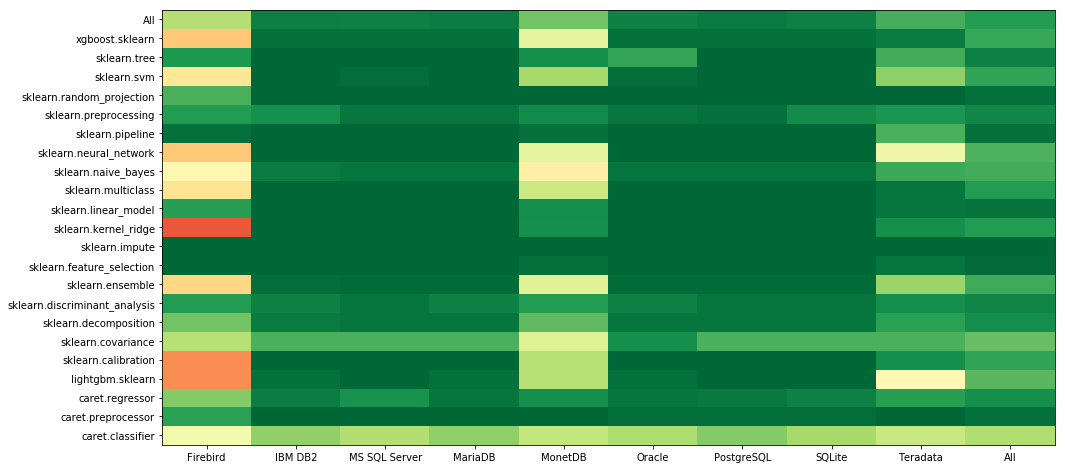

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.pcolor(1-pvt, cmap='RdYlGn' , vmin=0 , vmax=1)
plt.yticks(np.arange(0.5, len(pvt.index), 1), pvt.index)
plt.xticks(np.arange(0.5, len(pvt.columns), 1), [col[1] for col in pvt.columns])
fig = plt.gcf()
fig.set_size_inches(16, 8)

plt.show()       
    

In [40]:
Category_Labels = df.model_category.unique()


In [41]:
Category_Labels

array(['lightgbm.sklearn', 'caret.classifier', 'caret.preprocessor',
       'caret.regressor', 'sklearn.calibration', 'sklearn.covariance',
       'sklearn.decomposition', 'sklearn.discriminant_analysis',
       'sklearn.ensemble', 'sklearn.feature_selection', 'sklearn.impute',
       'sklearn.kernel_ridge', 'sklearn.linear_model',
       'sklearn.multiclass', 'sklearn.naive_bayes',
       'sklearn.neural_network', 'sklearn.pipeline',
       'sklearn.preprocessing', 'sklearn.random_projection',
       'sklearn.svm', 'sklearn.tree', 'xgboost.sklearn'], dtype=object)

In [42]:





for cat in Category_Labels:
    print("ERROR_REPORT_FOR_CATEGORY" , cat)
    df1 = df[df.model_category == cat]
    real_errors = df1 # df1[df1.error_message != "SUCCESS"]
    if(real_errors.shape[0] > 0):
        msg_by_estim_and_dsn = pd.DataFrame(real_errors.groupby(['dialect'])['error_message'].value_counts())
        from IPython.core.display import display, HTML
        display(msg_by_estim_and_dsn)
        pvt1 = pd.pivot_table(df1, index='Model', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)
        display(pvt1)
    else:
        print("NO_ERROR_FOR_CATEGORY" , cat)
    

ERROR_REPORT_FOR_CATEGORY lightgbm.sklearn


error_message
dialect       error_message                                              
Firebird      "DatabaseError:('Error                                   30
              SUCCESS                                                  12
              'DatabaseError:(fdb.fbcore.DatabaseError)                 6
IBM DB2       SUCCESS                                                  47
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
MS SQL Server SUCCESS                                                  48
MariaDB       SUCCESS                                                  47
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
MonetDB       SUCCESS                                                  32
              'IntegrityError:COMMIT:                                  16
Oracle        SUCCESS                                                  47
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
PostgreSQL    SUCCESS                                                  48
SQLite        SUCCESS                                                  48
Teradata      SUCCESS                                                  23
              TIMEOUT                                                  23
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
              'DatabaseError:(teradata.api.DatabaseError)               1

mean                                              \
dialect              Firebird   IBM DB2 MS SQL Server   MariaDB   MonetDB   
Model                                                                       
LGBMClassifier       0.888889  0.000000           0.0  0.000000  0.333333   
LGBMClassifier_pipe  0.777778  0.055556           0.0  0.055556  0.388889   
LGBMRegressor        0.333333  0.000000           0.0  0.000000  0.166667   
LGBMRegressor_pipe   0.666667  0.000000           0.0  0.000000  0.333333   
All                  0.750000  0.020833           0.0  0.020833  0.333333   

                                                                     
dialect                Oracle PostgreSQL SQLite  Teradata       All  
Model                                                                
LGBMClassifier       0.000000        0.0    0.0  0.611111  0.203704  
LGBMClassifier_pipe  0.055556        0.0    0.0  0.722222  0.228395  
LGBMRegressor        0.000000        0.0    0.0  0.000000  0.055556  
LGBMRegressor_pipe   0.000000        0.0    0.0  0.166667  0.129630  
All                  0.020833        0.0    0.0  0.520833  0.185185

ERROR_REPORT_FOR_CATEGORY caret.classifier


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                       153
              'DatabaseError:(fdb.fbcore.DatabaseError)                      47
              "cTrainingError:Exception:TRAIN_FAILED                         31
              "DatabaseError:('Error                                         30
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
              "TypeError:ufunc                                                6
              TIMEOUT                                                         5
              "DatabaseError:(fdb.fbcore.DatabaseError)                       3
              'IndexError:list                                                1
IBM DB2       SUCCESS                                                       217
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   38
              "cTrainingError:Exception:TRAIN_FAILED                         35
              "TypeError:ufunc                                                6
MS SQL Server SUCCESS                                                       201
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   36
              "cTrainingError:Exception:TRAIN_FAILED                         33
              125, b'Case expressions may only be nested to l...             18
              "TypeError:ufunc                                                6
              701, b"There is insufficient system memory in r...              3
              "FileNotFoundError:File                                         1
MariaDB       SUCCESS                                                       224
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   42
              "cTrainingError:Exception:TRAIN_FAILED                         30
              "TypeError:ufunc                                                6
              "FileNotFoundError:File                                         1
              'IndexError:list                                                1
              'ValueError:Length                                              1
MonetDB       SUCCESS                                                       181
              "cTrainingError:Exception:TRAIN_FAILED                         28
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   25
...                                                                         ...
              TIMEOUT                                                        11
              "TypeError:ufunc                                                6
              'DBAPIError:(builtins.BrokenPipeError)                          5
              "FileNotFoundError:File                                         3
              'ValueError:Length                                              1
Oracle        SUCCESS                                                       217
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   56
              "cTrainingError:Exception:TRAIN_FAILED                         37
              "TypeError:ufunc                                                6
              'IndexError:list                                                1
PostgreSQL    SUCCESS                                                       226
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   38
              "cTrainingError:Exception:TRAIN_FAILED                         30
              "TypeError:ufunc                                                5
              'IndexError:list                                                1
SQLite        SUCCESS                                                       221
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   48
              "cTrainingError:Exception:TRAIN_FAILED              

mean                                              \
dialect                Firebird   IBM DB2 MS SQL Server   MariaDB   MonetDB   
Model                                                                         
caret_class_ctree      0.000000  0.111111      0.000000  0.055556  0.000000   
caret_class_ctree2     0.037037  0.000000      0.057143  0.000000  0.029412   
caret_class_glm        0.833333  0.833333      0.833333  0.833333  0.833333   
caret_class_glmnet     0.342857  0.138889      0.222222  0.166667  0.200000   
caret_class_nnet       0.814815  0.342857      0.382353  0.333333  0.703704   
caret_class_rf         0.555556  0.000000      0.500000  0.000000  0.333333   
caret_class_rpart      0.027778  0.055556      0.000000  0.027778  0.000000   
caret_class_svmRadial  0.909091  0.625000      0.645161  0.657143  0.645161   
caret_class_xgbTree    0.791667  0.333333      0.333333  0.360000  0.722222   
All                    0.468750  0.266892      0.325503  0.265574  0.355872   

                                                                          
dialect                  Oracle PostgreSQL    SQLite  Teradata       All  
Model                                                                     
caret_class_ctree      0.055556   0.000000  0.083333  0.000000  0.034161  
caret_class_ctree2     0.138889   0.000000  0.083333  0.000000  0.038462  
caret_class_glm        1.000000   0.833333  0.833333  0.833333  0.851852  
caret_class_glmnet     0.138889   0.138889  0.138889  0.433333  0.209003  
caret_class_nnet       0.361111   0.352941  0.361111  0.371429  0.431973  
caret_class_rf         0.000000   0.000000  0.055556  0.480000  0.207237  
caret_class_rpart      0.111111   0.027778  0.111111  0.111111  0.052469  
caret_class_svmRadial  0.676471   0.625000  0.666667  0.677419  0.681356  
caret_class_xgbTree    0.387097   0.333333  0.413793  0.560000  0.470874  
All                    0.315457   0.246667  0.302839  0.368966  0.322808

ERROR_REPORT_FOR_CATEGORY caret.preprocessor


error_message
dialect       error_message                                           
Firebird      SUCCESS                                               63
              'DatabaseError:(fdb.fbcore.DatabaseError)              8
              'IndexError:list                                       1
IBM DB2       SUCCESS                                               72
MS SQL Server SUCCESS                                               72
MariaDB       SUCCESS                                               72
MonetDB       SUCCESS                                               72
Oracle        SUCCESS                                               71
              "Exception:PREDICT_FAILED                              1
PostgreSQL    SUCCESS                                               71
              'IndexError:list                                       1
SQLite        SUCCESS                                               71
              "Exception:PREDICT_FAILED                              1
Teradata      SUCCESS                                               72

mean                                        \
dialect                  Firebird IBM DB2 MS SQL Server MariaDB MonetDB   
Model                                                                     
caret_prep_center_scale  0.000000     0.0           0.0     0.0     0.0   
caret_prep_ica           0.041667     0.0           0.0     0.0     0.0   
caret_prep_pca           0.333333     0.0           0.0     0.0     0.0   
All                      0.125000     0.0           0.0     0.0     0.0   

                                                                           
dialect                    Oracle PostgreSQL    SQLite Teradata       All  
Model                                                                      
caret_prep_center_scale  0.000000   0.000000  0.000000      0.0  0.000000  
caret_prep_ica           0.041667   0.041667  0.041667      0.0  0.018519  
caret_prep_pca           0.000000   0.000000  0.000000      0.0  0.037037  
All                      0.013889   0.013889  0.013889      0.0  0.018519

ERROR_REPORT_FOR_CATEGORY caret.regressor


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        79
              'DatabaseError:(fdb.fbcore.DatabaseError)                      11
              "DatabaseError:('Error                                          6
              "cTrainingError:Exception:TRAIN_FAILED                          4
              "DatabaseError:(fdb.fbcore.DatabaseError)                       2
              "Exception:PREDICT_FAILED                                       1
              "TypeError:ufunc                                                1
              'KeyError:5'),                                                  1
IBM DB2       SUCCESS                                                       102
              "cTrainingError:Exception:TRAIN_FAILED                          4
              "TypeError:ufunc                                                1
MS SQL Server SUCCESS                                                        97
              125, b'Case expressions may only be nested to l...              6
              "cTrainingError:Exception:TRAIN_FAILED                          3
              "TypeError:ufunc                                                1
MariaDB       SUCCESS                                                       105
              "cTrainingError:Exception:TRAIN_FAILED                          2
              "TypeError:ufunc                                                1
MonetDB       SUCCESS                                                        96
              'IntegrityError:COMMIT:                                         4
              "cTrainingError:Exception:TRAIN_FAILED                          2
              'DBAPIError:(builtins.BrokenPipeError)                          2
              "TypeError:ufunc                                                1
Oracle        SUCCESS                                                       105
              "cTrainingError:Exception:TRAIN_FAILED                          2
              "TypeError:ufunc                                                1
PostgreSQL    SUCCESS                                                       103
              "cTrainingError:Exception:TRAIN_FAILED                          2
              "Exception:PREDICT_FAILED                                       1
              "TypeError:ufunc                                                1
SQLite        SUCCESS                                                       100
              "cTrainingError:Exception:TRAIN_FAILED                          3
              "Exception:PREDICT_FAILED                                       1
              "TypeError:ufunc                                                1
              ) parser stack overflo                                          1
Teradata      SUCCESS                                                        95
              'DatabaseError:(teradata.api.DatabaseError)                     8
              "cTrainingError:Exception:TRAIN_FAILED                          3
              "KeyError:'XD_6'"),                                             1
              "TypeError:ufunc                                                1

mean                                              \
dialect              Firebird   IBM DB2 MS SQL Server   MariaDB   MonetDB   
Model                                                                       
caret_reg_ctree      0.166667  0.000000      0.000000  0.000000  0.166667   
caret_reg_ctree2     0.000000  0.000000      0.000000  0.000000  0.000000   
caret_reg_glm        0.250000  0.083333      0.083333  0.083333  0.083333   
caret_reg_glmnet     0.000000  0.166667      0.250000  0.000000  0.000000   
caret_reg_nnet       0.000000  0.000000      0.000000  0.000000  0.000000   
caret_reg_rf         0.750000  0.166667      0.500000  0.000000  0.250000   
caret_reg_rpart      0.000000  0.000000      0.000000  0.000000  0.166667   
caret_reg_svmRadial  0.700000  0.000000      0.000000  0.000000  0.000000   
caret_reg_xgbTree    0.454545  0.000000      0.000000  0.166667  0.111111   
All                  0.247619  0.046729      0.093458  0.027778  0.085714   

                                                                        
dialect                Oracle PostgreSQL    SQLite  Teradata       All  
Model                                                                   
caret_reg_ctree      0.000000   0.000000  0.000000  0.000000  0.037736  
caret_reg_ctree2     0.000000   0.000000  0.000000  0.000000  0.000000  
caret_reg_glm        0.083333   0.083333  0.083333  0.083333  0.101852  
caret_reg_glmnet     0.000000   0.166667  0.000000  0.083333  0.074074  
caret_reg_nnet       0.000000   0.000000  0.000000  0.000000  0.000000  
caret_reg_rf         0.000000   0.000000  0.083333  0.500000  0.250000  
caret_reg_rpart      0.166667   0.083333  0.000000  0.000000  0.046296  
caret_reg_svmRadial  0.000000   0.000000  0.000000  0.416667  0.113208  
caret_reg_xgbTree    0.000000   0.000000  0.333333  0.000000  0.118812  
All                  0.027778   0.037383  0.056604  0.120370  0.082206

ERROR_REPORT_FOR_CATEGORY sklearn.calibration


error_message
dialect       error_message                                              
Firebird      "DatabaseError:('Error                                   12
              TIMEOUT                                                  10
              SUCCESS                                                   9
              'DatabaseError:(fdb.fbcore.DatabaseError)                 5
IBM DB2       SUCCESS                                                  36
MS SQL Server SUCCESS                                                  36
MariaDB       SUCCESS                                                  36
MonetDB       SUCCESS                                                  24
              'IntegrityError:COMMIT:                                  12
Oracle        SUCCESS                                                  36
PostgreSQL    SUCCESS                                                  36
SQLite        SUCCESS                                                  36
Teradata      SUCCESS                                                  33
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
              'DatabaseError:(teradata.api.DatabaseError)               1

mean                                          \
dialect                      Firebird IBM DB2 MS SQL Server MariaDB   MonetDB   
Model                                                                           
CalibratedClassifierCV       0.666667     0.0           0.0     0.0  0.388889   
CalibratedClassifierCV_pipe  0.833333     0.0           0.0     0.0  0.277778   
All                          0.750000     0.0           0.0     0.0  0.333333   

                                                                          
dialect                     Oracle PostgreSQL SQLite  Teradata       All  
Model                                                                     
CalibratedClassifierCV         0.0        0.0    0.0  0.055556  0.123457  
CalibratedClassifierCV_pipe    0.0        0.0    0.0  0.111111  0.135802  
All                            0.0        0.0    0.0  0.083333  0.129630

ERROR_REPORT_FOR_CATEGORY sklearn.covariance


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                         8
              "DatabaseError:('Error                                          2
              'DatabaseError:(fdb.fbcore.DatabaseError)                       2
IBM DB2       SUCCESS                                                        10
              'InternalError:(ibm_db_dbi.InternalError)                       2
MS SQL Server SUCCESS                                                        10
              8631, b'Internal error: Server stack limit has ...              2
MariaDB       SUCCESS                                                        10
              1436, "Thread stack overrun:  1238176 bytes use...              2
MonetDB       SUCCESS                                                         7
              'IntegrityError:COMMIT:                                         3
              TIMEOUT                                                         2
Oracle        SUCCESS                                                        11
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
PostgreSQL    SUCCESS                                                        10
              ) stack depth limit exceededHINT:  Increase the...              2
SQLite        SUCCESS                                                        10
              ) Expression tree is too large (maximum depth 1000              2
Teradata      SUCCESS                                                        10
              'DatabaseError:(teradata.api.DatabaseError)                     2

mean                                              \
dialect                Firebird   IBM DB2 MS SQL Server   MariaDB   MonetDB   
Model                                                                         
EllipticEnvelope       0.333333  0.333333      0.333333  0.333333  0.333333   
EllipticEnvelope_pipe  0.333333  0.000000      0.000000  0.000000  0.500000   
All                    0.333333  0.166667      0.166667  0.166667  0.416667   

                                                                          
dialect                  Oracle PostgreSQL    SQLite  Teradata       All  
Model                                                                     
EllipticEnvelope       0.166667   0.333333  0.333333  0.333333  0.314815  
EllipticEnvelope_pipe  0.000000   0.000000  0.000000  0.000000  0.092593  
All                    0.083333   0.166667  0.166667  0.166667  0.203704

ERROR_REPORT_FOR_CATEGORY sklearn.decomposition


error_message
dialect       error_message                                              
Firebird      SUCCESS                                                  56
              'DatabaseError:(fdb.fbcore.DatabaseError)                12
              "DatabaseError:(fdb.fbcore.DatabaseError)                 4
IBM DB2       SUCCESS                                                  69
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
              'DBAPIError:(ibm_db_dbi.Error)                            1
MS SQL Server SUCCESS                                                  70
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
MariaDB       SUCCESS                                                  70
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
MonetDB       SUCCESS                                                  58
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             14
Oracle        SUCCESS                                                  70
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
PostgreSQL    SUCCESS                                                  70
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
SQLite        SUCCESS                                                  70
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
Teradata      SUCCESS                                                  63
              'DatabaseError:(teradata.api.DatabaseError)               6
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
              TIMEOUT                                                   1

mean                                              \
dialect         Firebird   IBM DB2 MS SQL Server   MariaDB   MonetDB   
Model                                                                  
FactorAnalysis  0.000000  0.000000      0.000000  0.000000  1.000000   
FastICA         0.333333  0.166667      0.166667  0.166667  0.166667   
IncrementalPCA  0.000000  0.000000      0.000000  0.000000  0.000000   
KernelPCA       1.000000  0.083333      0.000000  0.000000  0.000000   
PCA             0.000000  0.000000      0.000000  0.000000  0.000000   
TruncatedSVD    0.000000  0.000000      0.000000  0.000000  0.000000   
All             0.222222  0.041667      0.027778  0.027778  0.194444   

                                                                  
dialect           Oracle PostgreSQL    SQLite Teradata       All  
Model                                                             
FactorAnalysis  0.000000   0.000000  0.000000    0.000  0.111111  
FastICA         0.166667   0.166667  0.166667    0.250  0.194444  
IncrementalPCA  0.000000   0.000000  0.000000    0.000  0.000000  
KernelPCA       0.000000   0.000000  0.000000    0.500  0.175926  
PCA             0.000000   0.000000  0.000000    0.000  0.000000  
TruncatedSVD    0.000000   0.000000  0.000000    0.000  0.000000  
All             0.027778   0.027778  0.027778    0.125  0.080247

ERROR_REPORT_FOR_CATEGORY sklearn.discriminant_analysis


error_message
dialect       error_message                                              
Firebird      SUCCESS                                                  32
              'DatabaseError:(fdb.fbcore.DatabaseError)                 2
              "DatabaseError:('Error                                    1
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
IBM DB2       SUCCESS                                                  34
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
MS SQL Server SUCCESS                                                  35
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
MariaDB       SUCCESS                                                  34
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
MonetDB       SUCCESS                                                  32
              'IntegrityError:COMMIT:                                   3
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
Oracle        SUCCESS                                                  34
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
PostgreSQL    SUCCESS                                                  35
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
SQLite        SUCCESS                                                  35
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
Teradata      SUCCESS                                                  33
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
              'DatabaseError:(teradata.api.DatabaseError)               1

mean                                    \
dialect                          Firebird   IBM DB2 MS SQL Server   MariaDB   
Model                                                                         
LinearDiscriminantAnalysis       0.111111  0.000000      0.000000  0.000000   
LinearDiscriminantAnalysis_pipe  0.111111  0.111111      0.055556  0.111111   
All                              0.111111  0.055556      0.027778  0.055556   

                                                                          \
dialect                           MonetDB    Oracle PostgreSQL    SQLite   
Model                                                                      
LinearDiscriminantAnalysis       0.000000  0.000000   0.000000  0.000000   
LinearDiscriminantAnalysis_pipe  0.222222  0.111111   0.055556  0.055556   
All                              0.111111  0.055556   0.027778  0.027778   

                                                     
dialect                          Teradata       All  
Model                                                
LinearDiscriminantAnalysis       0.000000  0.012346  
LinearDiscriminantAnalysis_pipe  0.166667  0.111111  
All                              0.083333  0.061728

ERROR_REPORT_FOR_CATEGORY sklearn.ensemble


error_message
dialect       error_message                                              
Firebird      "DatabaseError:('Error                                  115
              SUCCESS                                                  97
              'DatabaseError:(fdb.fbcore.DatabaseError)                39
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
IBM DB2       SUCCESS                                                 249
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
MS SQL Server SUCCESS                                                 250
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
MariaDB       SUCCESS                                                 250
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
MonetDB       SUCCESS                                                 146
              'IntegrityError:COMMIT:                                  93
              'DBAPIError:(builtins.BrokenPipeError)                    7
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
              "Exception:CONNECTION_FAILED_WITH_ERROR                   2
              TIMEOUT                                                   2
Oracle        SUCCESS                                                 250
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
PostgreSQL    SUCCESS                                                 250
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
SQLite        SUCCESS                                                 250
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
Teradata      SUCCESS                                                 181
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             53
              'DatabaseError:(teradata.api.DatabaseError)              10
              TIMEOUT                                                   8

mean                                    \
dialect                          Firebird   IBM DB2 MS SQL Server   MariaDB   
Model                                                                         
AdaBoostClassifier               0.944444  0.000000      0.000000  0.000000   
AdaBoostClassifier_pipe          1.000000  0.055556      0.000000  0.000000   
AdaBoostRegressor                0.000000  0.000000      0.000000  0.000000   
AdaBoostRegressor_pipe           0.666667  0.000000      0.000000  0.000000   
BaggingClassifier                0.388889  0.000000      0.000000  0.000000   
BaggingClassifier_pipe           0.500000  0.000000      0.000000  0.000000   
BaggingRegressor                 0.666667  0.000000      0.000000  0.000000   
BaggingRegressor_pipe            0.666667  0.000000      0.000000  0.000000   
ExtraTreesClassifier             0.333333  0.000000      0.000000  0.000000   
ExtraTreesClassifier_pipe        0.722222  0.111111      0.111111  0.111111   
ExtraTreesRegressor              0.666667  0.000000      0.000000  0.000000   
ExtraTreesRegressor_pipe         0.500000  0.000000      0.000000  0.000000   
GradientBoostingClassifier       0.777778  0.000000      0.000000  0.000000   
GradientBoostingClassifier_pipe  0.666667  0.000000      0.000000  0.000000   
GradientBoostingRegressor        0.500000  0.000000      0.000000  0.000000   
GradientBoostingRegressor_pipe   0.500000  0.000000      0.000000  0.000000   
IsolationForest                  0.666667  0.000000      0.000000  0.000000   
IsolationForest_pipe             0.833333  0.000000      0.000000  0.000000   
RandomForestClassifier           0.388889  0.000000      0.000000  0.000000   
RandomForestClassifier_pipe      0.666667  0.000000      0.000000  0.000000   
RandomForestRegressor            0.333333  0.000000      0.000000  0.000000   
RandomForestRegressor_pipe       0.666667  0.000000      0.000000  0.000000   
All                              0.615079  0.011905      0.007937  0.007937   

                                                                          \
dialect                           MonetDB    Oracle PostgreSQL    SQLite   
Model                                                                      
AdaBoostClassifier               0.555556  0.000000   0.000000  0.000000   
AdaBoostClassifier_pipe          0.666667  0.000000   0.000000  0.000000   
AdaBoostRegressor                0.166667  0.000000   0.000000  0.000000   
AdaBoostRegressor_pipe           0.500000  0.000000   0.000000  0.000000   
BaggingClassifier                0.555556  0.000000   0.000000  0.000000   
BaggingClassifier_pipe           0.555556  0.000000   0.000000  0.000000   
BaggingRegressor                 0.166667  0.000000   0.000000  0.000000   
BaggingRegressor_pipe            0.666667  0.000000   0.000000  0.000000   
ExtraTreesClassifier             0.277778  0.000000   0.000000  0.000000   
ExtraTreesClassifier_pipe        0.444444  0.111111   0.111111  0.111111   
ExtraTreesRegressor              0.500000  0.000000   0.000000  0.000000   
ExtraTreesRegressor_pipe         0.166667  0.000000   0.000000  0.000000   
GradientBoostingClassifier       0.166667  0.000000   0.000000  0.000000   
GradientBoostingClassifier_pipe  0.333333  0.000000   0.000000  0.000000   
GradientBoostingRegressor        0.333333  0.000000   0.000000  0.000000   
GradientBoostingRegressor_pipe   0.333333  0.000000   0.000000  0.000000   
IsolationForest                  0.500000  0.000000   0.000000  0.000000   
IsolationForest_pipe             0.166667  0.000000   0.000000  0.000000   
RandomForestClassifier           0.277778  0.000000   0.000000  0.000000   
RandomForestClassifier_pipe      0.611111  0.000000   0.000000  0.000000   
RandomForestRegressor            0.333333  0.000000   0.000000  0.000000   
RandomForestRegressor_pipe       0.500000  0.000000   0.000000  0.000000   
All                              0.420635  0.007937   0.007937  0.007937   

     

ERROR_REPORT_FOR_CATEGORY sklearn.feature_selection


error_message
dialect       error_message                                         
Firebird      SUCCESS                                            108
IBM DB2       SUCCESS                                            108
MS SQL Server SUCCESS                                            108
MariaDB       SUCCESS                                            108
MonetDB       SUCCESS                                            106
              "Exception:CONNECTION_FAILED_WITH_ERROR              2
Oracle        SUCCESS                                            108
PostgreSQL    SUCCESS                                            108
SQLite        SUCCESS                                            108
Teradata      SUCCESS                                            105
              TIMEOUT                                              3

mean                                          \
dialect                 Firebird IBM DB2 MS SQL Server MariaDB   MonetDB   
Model                                                                      
GenericUnivariateSelect      0.0     0.0           0.0     0.0  0.000000   
RFE                          0.0     0.0           0.0     0.0  0.000000   
RFECV                        0.0     0.0           0.0     0.0  0.000000   
SelectFdr                    0.0     0.0           0.0     0.0  0.000000   
SelectFpr                    0.0     0.0           0.0     0.0  0.000000   
SelectFromModel              0.0     0.0           0.0     0.0  0.166667   
SelectFwe                    0.0     0.0           0.0     0.0  0.000000   
SelectKBest                  0.0     0.0           0.0     0.0  0.000000   
SelectPercentile             0.0     0.0           0.0     0.0  0.000000   
All                          0.0     0.0           0.0     0.0  0.018519   

                                                                      
dialect                 Oracle PostgreSQL SQLite  Teradata       All  
Model                                                                 
GenericUnivariateSelect    0.0        0.0    0.0  0.000000  0.000000  
RFE                        0.0        0.0    0.0  0.000000  0.000000  
RFECV                      0.0        0.0    0.0  0.000000  0.000000  
SelectFdr                  0.0        0.0    0.0  0.000000  0.000000  
SelectFpr                  0.0        0.0    0.0  0.000000  0.000000  
SelectFromModel            0.0        0.0    0.0  0.000000  0.018519  
SelectFwe                  0.0        0.0    0.0  0.000000  0.000000  
SelectKBest                0.0        0.0    0.0  0.250000  0.027778  
SelectPercentile           0.0        0.0    0.0  0.000000  0.000000  
All                        0.0        0.0    0.0  0.027778  0.005144

ERROR_REPORT_FOR_CATEGORY sklearn.impute


,,error_message
dialect,error_message,
Firebird,SUCCESS,24
IBM DB2,SUCCESS,24
MS SQL Server,SUCCESS,24
MariaDB,SUCCESS,24
MonetDB,SUCCESS,24
Oracle,SUCCESS,24
PostgreSQL,SUCCESS,24
SQLite,SUCCESS,24
Teradata,SUCCESS,24


mean                                               \
dialect          Firebird IBM DB2 MS SQL Server MariaDB MonetDB Oracle   
Model                                                                    
MissingIndicator        0       0             0       0       0      0   
SimpleImputer           0       0             0       0       0      0   
All                     0       0             0       0       0      0   

                                                 
dialect          PostgreSQL SQLite Teradata All  
Model                                            
MissingIndicator          0      0        0   0  
SimpleImputer             0      0        0   0  
All                       0      0        0   0

ERROR_REPORT_FOR_CATEGORY sklearn.kernel_ridge


error_message
dialect       error_message                                             
Firebird      "DatabaseError:(fdb.fbcore.DatabaseError)                5
              'DatabaseError:(fdb.fbcore.DatabaseError)                3
              "DatabaseError:('Error                                   2
              SUCCESS                                                  2
IBM DB2       SUCCESS                                                 12
MS SQL Server SUCCESS                                                 12
MariaDB       SUCCESS                                                 12
MonetDB       SUCCESS                                                 11
              'IntegrityError:COMMIT:                                  1
Oracle        SUCCESS                                                 12
PostgreSQL    SUCCESS                                                 12
SQLite        SUCCESS                                                 12
Teradata      SUCCESS                                                 11
              'DatabaseError:(teradata.api.DatabaseError)              1

mean                                                 \
dialect           Firebird IBM DB2 MS SQL Server MariaDB   MonetDB Oracle   
Model                                                                       
KernelRidge       1.000000     0.0           0.0     0.0  0.000000    0.0   
KernelRidge_pipe  0.666667     0.0           0.0     0.0  0.166667    0.0   
All               0.833333     0.0           0.0     0.0  0.083333    0.0   

                                                        
dialect          PostgreSQL SQLite  Teradata       All  
Model                                                   
KernelRidge             0.0    0.0  0.166667  0.129630  
KernelRidge_pipe        0.0    0.0  0.000000  0.092593  
All                     0.0    0.0  0.083333  0.111111

ERROR_REPORT_FOR_CATEGORY sklearn.linear_model


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                       433
              "DatabaseError:('Error                                         54
              'DatabaseError:(fdb.fbcore.DatabaseError)                       4
              'cTrainingError:ValueError:`min_samples` may no...              1
IBM DB2       SUCCESS                                                       491
              'cTrainingError:ValueError:`min_samples` may no...              1
MS SQL Server SUCCESS                                                       491
              'cTrainingError:ValueError:`min_samples` may no...              1
MariaDB       SUCCESS                                                       491
              'cTrainingError:ValueError:`min_samples` may no...              1
MonetDB       SUCCESS                                                       453
              'IntegrityError:COMMIT:                                        38
              'cTrainingError:ValueError:`min_samples` may no...              1
Oracle        SUCCESS                                                       491
              'cTrainingError:ValueError:`min_samples` may no...              1
PostgreSQL    SUCCESS                                                       491
              'cTrainingError:ValueError:`min_samples` may no...              1
SQLite        SUCCESS                                                       491
              'cTrainingError:ValueError:`min_samples` may no...              1
Teradata      SUCCESS                                                       478
              'DatabaseError:(teradata.api.DatabaseError)                     7
              TIMEOUT                                                         6
              'cTrainingError:ValueError:`min_samples` may no...              1

mean                                    \
dialect                           Firebird   IBM DB2 MS SQL Server   MariaDB   
Model                                                                          
ARDRegression                     0.000000  0.000000      0.000000  0.000000   
ARDRegression_pipe                0.333333  0.000000      0.000000  0.000000   
BayesianRidge                     0.000000  0.000000      0.000000  0.000000   
BayesianRidge_pipe                0.333333  0.000000      0.000000  0.000000   
ElasticNet                        0.000000  0.000000      0.000000  0.000000   
ElasticNetCV                      0.000000  0.000000      0.000000  0.000000   
ElasticNetCV_pipe                 0.500000  0.000000      0.000000  0.000000   
ElasticNet_pipe                   0.333333  0.000000      0.000000  0.000000   
Lars                              0.000000  0.000000      0.000000  0.000000   
LarsCV                            0.000000  0.000000      0.000000  0.000000   
LarsCV_pipe                       0.333333  0.000000      0.000000  0.000000   
Lars_pipe                         0.333333  0.000000      0.000000  0.000000   
Lasso                             0.000000  0.000000      0.000000  0.000000   
LassoCV                           0.000000  0.000000      0.000000  0.000000   
LassoCV_pipe                      0.333333  0.000000      0.000000  0.000000   
LassoLars                         0.000000  0.000000      0.000000  0.000000   
LassoLarsCV                       0.000000  0.000000      0.000000  0.000000   
LassoLarsCV_pipe                  0.333333  0.000000      0.000000  0.000000   
LassoLarsIC                       0.000000  0.000000      0.000000  0.000000   
LassoLarsIC_pipe                  0.333333  0.000000      0.000000  0.000000   
LassoLars_pipe                    0.333333  0.000000      0.000000  0.000000   
Lasso_pipe                        0.333333  0.000000      0.000000  0.000000   
LinearRegression                  0.000000  0.000000      0.000000  0.000000   
LinearRegression_pipe             0.333333  0.000000      0.000000  0.000000   
LogisticRegression                0.111111  0.000000      0.000000  0.000000   
LogisticRegressionCV              0.111111  0.000000      0.000000  0.000000   
LogisticRegressionCV_pipe         0.111111  0.000000      0.000000  0.000000   
LogisticRegression_pipe           0.055556  0.000000      0.000000  0.000000   
OrthogonalMatchingPursuit         0.000000  0.000000      0.000000  0.000000   
OrthogonalMatchingPursuitCV       0.000000  0.000000      0.000000  0.000000   
OrthogonalMatchingPursuitCV_pipe  0.166667  0.000000      0.000000  0.000000   
OrthogonalMatchingPursuit_pipe    0.500000  0.000000      0.000000  0.000000   
PassiveAggressiveClassifier       0.000000  0.000000      0.000000  0.000000   
PassiveAggressiveClassifier_pipe  0.055556  0.000000      0.000000  0.000000   
PassiveAggressiveRegressor        0.000000  0.000000      0.000000  0.000000   
PassiveAggressiveRegressor_pipe   0.333333  0.000000      0.000000  0.000000   
Perceptron                        0.000000  0.000000      0.000000  0.000000   
Perceptron_pipe                   0.055556  0.000000      0.000000  0.000000   
RANSACRegressor                   0.166667  0.166667      0.166667  0.166667   
RANSACRegressor_pipe              0.333333  0.000000      0.000000  0.000000   
Ridge                             0.000000  0.000000      0.000000  0.000000   
RidgeCV                           0.000000  0.000000      0.000000  0.000000   
RidgeCV_pipe                      0.333333  0.000000      0.000000  0.000000   
RidgeClassifier                   0.000000  0.000000      0.000000  0.000000   
RidgeClassifierCV                 0.000000  0.000000      0.000000  0.000000   
RidgeClassifierCV_pipe            0.111111  0.000000      0.000000  0.000000   
RidgeClassifier_pipe              0.055556  0.000000      0.000000  0.000000   
Ridge_pipe                        0.66

ERROR_REPORT_FOR_CATEGORY sklearn.multiclass


error_message
dialect       error_message                                             
Firebird      "DatabaseError:('Error                                  35
              SUCCESS                                                 30
              'DatabaseError:(fdb.fbcore.DatabaseError)                5
              TIMEOUT                                                  2
IBM DB2       SUCCESS                                                 72
MS SQL Server SUCCESS                                                 72
MariaDB       SUCCESS                                                 72
MonetDB       SUCCESS                                                 45
              'IntegrityError:COMMIT:                                 27
Oracle        SUCCESS                                                 72
PostgreSQL    SUCCESS                                                 72
SQLite        SUCCESS                                                 72
Teradata      SUCCESS                                                 70
              'DatabaseError:(teradata.api.DatabaseError)              2

mean                                          \
dialect                   Firebird IBM DB2 MS SQL Server MariaDB   MonetDB   
Model                                                                        
OneVsOneClassifier        0.555556     0.0           0.0     0.0  0.388889   
OneVsOneClassifier_pipe   0.666667     0.0           0.0     0.0  0.555556   
OneVsRestClassifier       0.444444     0.0           0.0     0.0  0.222222   
OneVsRestClassifier_pipe  0.666667     0.0           0.0     0.0  0.333333   
All                       0.583333     0.0           0.0     0.0  0.375000   

                                                                       
dialect                  Oracle PostgreSQL SQLite  Teradata       All  
Model                                                                  
OneVsOneClassifier          0.0        0.0    0.0  0.000000  0.104938  
OneVsOneClassifier_pipe     0.0        0.0    0.0  0.055556  0.141975  
OneVsRestClassifier         0.0        0.0    0.0  0.000000  0.074074  
OneVsRestClassifier_pipe    0.0        0.0    0.0  0.055556  0.117284  
All                         0.0        0.0    0.0  0.027778  0.109568

ERROR_REPORT_FOR_CATEGORY sklearn.naive_bayes


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        68
              'DatabaseError:(fdb.fbcore.DatabaseError)                      39
              "DatabaseError:('Error                                         34
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
IBM DB2       SUCCESS                                                       138
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
              : Statement Execute Failed: [IBM][CLI Driver][D...              2
MS SQL Server SUCCESS                                                       140
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
MariaDB       SUCCESS                                                       140
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
MonetDB       SUCCESS                                                        65
              'IntegrityError:COMMIT:                                        32
              TIMEOUT                                                        28
              'DBAPIError:(builtins.BrokenPipeError)                         15
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
Oracle        SUCCESS                                                       140
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
PostgreSQL    SUCCESS                                                       140
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
SQLite        SUCCESS                                                       140
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
Teradata      SUCCESS                                                       123
              TIMEOUT                                                        15
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
              'DatabaseError:(teradata.api.DatabaseError)                     2

mean                                              \
dialect             Firebird   IBM DB2 MS SQL Server   MariaDB   MonetDB   
Model                                                                      
BernoulliNB         0.388889  0.000000      0.000000  0.000000  0.555556   
BernoulliNB_pipe    0.444444  0.000000      0.000000  0.000000  0.611111   
ComplementNB        0.611111  0.111111      0.111111  0.111111  0.444444   
ComplementNB_pipe   0.611111  0.111111      0.111111  0.111111  0.611111   
GaussianNB          0.500000  0.111111      0.000000  0.000000  0.611111   
GaussianNB_pipe     0.555556  0.000000      0.000000  0.000000  0.666667   
MultinomialNB       0.611111  0.000000      0.000000  0.000000  0.333333   
MultinomialNB_pipe  0.500000  0.000000      0.000000  0.000000  0.555556   
All                 0.527778  0.041667      0.027778  0.027778  0.548611   

                                                                       
dialect               Oracle PostgreSQL    SQLite  Teradata       All  
Model                                                                  
BernoulliNB         0.000000   0.000000  0.000000  0.222222  0.129630  
BernoulliNB_pipe    0.000000   0.000000  0.000000  0.222222  0.141975  
ComplementNB        0.111111   0.111111  0.111111  0.166667  0.209877  
ComplementNB_pipe   0.111111   0.111111  0.111111  0.166667  0.228395  
GaussianNB          0.000000   0.000000  0.000000  0.277778  0.166667  
GaussianNB_pipe     0.000000   0.000000  0.000000  0.055556  0.141975  
MultinomialNB       0.000000   0.000000  0.000000  0.000000  0.104938  
MultinomialNB_pipe  0.000000   0.000000  0.000000  0.055556  0.123457  
All                 0.027778   0.027778  0.027778  0.145833  0.155864

ERROR_REPORT_FOR_CATEGORY sklearn.neural_network


error_message
dialect       error_message                                           
Firebird      "DatabaseError:('Error                                23
              SUCCESS                                               17
              'DatabaseError:(fdb.fbcore.DatabaseError)              8
IBM DB2       SUCCESS                                               48
MS SQL Server SUCCESS                                               48
MariaDB       SUCCESS                                               48
MonetDB       SUCCESS                                               27
              'IntegrityError:COMMIT:                               21
Oracle        SUCCESS                                               48
PostgreSQL    SUCCESS                                               48
SQLite        SUCCESS                                               48
Teradata      SUCCESS                                               26
              TIMEOUT                                               22

mean                                                 \
dialect             Firebird IBM DB2 MS SQL Server MariaDB   MonetDB Oracle   
Model                                                                         
MLPClassifier       0.666667     0.0           0.0     0.0  0.333333    0.0   
MLPClassifier_pipe  0.611111     0.0           0.0     0.0  0.388889    0.0   
MLPRegressor        0.666667     0.0           0.0     0.0  0.666667    0.0   
MLPRegressor_pipe   0.666667     0.0           0.0     0.0  0.666667    0.0   
All                 0.645833     0.0           0.0     0.0  0.437500    0.0   

                                                          
dialect            PostgreSQL SQLite  Teradata       All  
Model                                                     
MLPClassifier             0.0    0.0  0.611111  0.179012  
MLPClassifier_pipe        0.0    0.0  0.611111  0.179012  
MLPRegressor              0.0    0.0  0.000000  0.148148  
MLPRegressor_pipe         0.0    0.0  0.000000  0.148148  
All                       0.0    0.0  0.458333  0.171296

ERROR_REPORT_FOR_CATEGORY sklearn.pipeline


error_message
dialect       error_message                         
Firebird      SUCCESS                             47
              "DatabaseError:('Error               1
IBM DB2       SUCCESS                             48
MS SQL Server SUCCESS                             48
MariaDB       SUCCESS                             48
MonetDB       SUCCESS                             47
              'IntegrityError:COMMIT:              1
Oracle        SUCCESS                             48
PostgreSQL    SUCCESS                             48
SQLite        SUCCESS                             48
Teradata      SUCCESS                             40
              TIMEOUT                              8

mean                                                 \
dialect        Firebird IBM DB2 MS SQL Server MariaDB   MonetDB Oracle   
Model                                                                    
FeatureUnion   0.000000     0.0           0.0     0.0  0.000000    0.0   
Pipeline       0.000000     0.0           0.0     0.0  0.000000    0.0   
Pipeline_pipe  0.055556     0.0           0.0     0.0  0.055556    0.0   
All            0.020833     0.0           0.0     0.0  0.020833    0.0   

                                                     
dialect       PostgreSQL SQLite  Teradata       All  
Model                                                
FeatureUnion         0.0    0.0  0.000000  0.000000  
Pipeline             0.0    0.0  0.111111  0.012346  
Pipeline_pipe        0.0    0.0  0.333333  0.049383  
All                  0.0    0.0  0.166667  0.023148

ERROR_REPORT_FOR_CATEGORY sklearn.preprocessing


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                       160
              'DatabaseError:(fdb.fbcore.DatabaseError)                      15
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
              "DatabaseError:(fdb.fbcore.DatabaseError)                       2
IBM DB2       SUCCESS                                                       164
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    7
              : SQLNumResultCols failed: [IBM][CLI Driver][DB...              5
              : SQLNumResultCols failed: [IBM][CLI Driver][DB...              4
MS SQL Server SUCCESS                                                       174
              125, b'Case expressions may only be nested to l...              6
MariaDB       SUCCESS                                                       174
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
MonetDB       SUCCESS                                                       167
              ) Math exception: Numerical argument out of domai              12
              TIMEOUT                                                         1
Oracle        SUCCESS                                                       174
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
PostgreSQL    SUCCESS                                                       176
              ) target lists can have at most 1664 entrie                     4
SQLite        SUCCESS                                                       166
              ) parser stack overflo                                          6
              ) too many columns in result se                                 4
              ) too many terms in compound SELEC                              4
Teradata      SUCCESS                                                       162
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    9
              TIMEOUT                                                         8
              'DatabaseError:(teradata.api.DatabaseError)                     1

mean                                              \
dialect              Firebird   IBM DB2 MS SQL Server   MariaDB   MonetDB   
Model                                                                       
Binarizer            0.000000  0.000000      0.000000  0.000000  0.000000   
KBinsDiscretizer     0.000000  0.000000      0.000000  0.000000  0.000000   
LabelBinarizer       0.000000  0.000000      0.000000  0.000000  0.000000   
LabelEncoder         0.000000  0.000000      0.000000  0.000000  0.000000   
MaxAbsScaler         0.000000  0.000000      0.000000  0.000000  0.000000   
MinMaxScaler         0.000000  0.000000      0.000000  0.000000  0.000000   
Normalizer           0.000000  0.000000      0.000000  0.000000  0.000000   
OneHotEncoder        0.000000  0.000000      0.000000  0.000000  0.000000   
OrdinalEncoder       0.500000  0.500000      0.500000  0.500000  0.083333   
PolynomialFeatures   0.333333  0.333333      0.000000  0.000000  0.000000   
PowerTransformer     0.000000  0.000000      0.000000  0.000000  1.000000   
QuantileTransformer  0.833333  0.500000      0.000000  0.000000  0.000000   
RobustScaler         0.000000  0.000000      0.000000  0.000000  0.000000   
StandardScaler       0.000000  0.000000      0.000000  0.000000  0.000000   
All                  0.111111  0.088889      0.033333  0.033333  0.072222   

                                                                        
dialect                Oracle PostgreSQL    SQLite  Teradata       All  
Model                                                                   
Binarizer            0.000000   0.000000  0.000000  0.000000  0.000000  
KBinsDiscretizer     0.000000   0.000000  0.000000  0.000000  0.000000  
LabelBinarizer       0.000000   0.000000  0.000000  0.000000  0.000000  
LabelEncoder         0.000000   0.000000  0.000000  0.000000  0.000000  
MaxAbsScaler         0.000000   0.000000  0.000000  0.000000  0.000000  
MinMaxScaler         0.000000   0.000000  0.000000  0.000000  0.000000  
Normalizer           0.000000   0.000000  0.000000  0.000000  0.000000  
OneHotEncoder        0.000000   0.000000  0.000000  0.000000  0.000000  
OrdinalEncoder       0.500000   0.000000  0.500000  0.500000  0.398148  
PolynomialFeatures   0.000000   0.333333  0.333333  0.333333  0.185185  
PowerTransformer     0.000000   0.000000  0.000000  0.000000  0.111111  
QuantileTransformer  0.000000   0.000000  0.333333  0.666667  0.259259  
RobustScaler         0.000000   0.000000  0.000000  0.000000  0.000000  
StandardScaler       0.000000   0.000000  0.000000  0.000000  0.000000  
All                  0.033333   0.022222  0.077778  0.100000  0.063580

ERROR_REPORT_FOR_CATEGORY sklearn.random_projection


error_message
dialect       error_message                                           
Firebird      SUCCESS                                               20
              "DatabaseError:(fdb.fbcore.DatabaseError)              4
IBM DB2       SUCCESS                                               24
MS SQL Server SUCCESS                                               24
MariaDB       SUCCESS                                               24
MonetDB       SUCCESS                                               24
Oracle        SUCCESS                                               24
PostgreSQL    SUCCESS                                               24
SQLite        SUCCESS                                               24
Teradata      SUCCESS                                               24

mean                                        \
dialect                   Firebird IBM DB2 MS SQL Server MariaDB MonetDB   
Model                                                                      
GaussianRandomProjection  0.333333     0.0           0.0     0.0     0.0   
SparseRandomProjection    0.000000     0.0           0.0     0.0     0.0   
All                       0.166667     0.0           0.0     0.0     0.0   

                                                                      
dialect                  Oracle PostgreSQL SQLite Teradata       All  
Model                                                                 
GaussianRandomProjection    0.0        0.0    0.0      0.0  0.037037  
SparseRandomProjection      0.0        0.0    0.0      0.0  0.000000  
All                         0.0        0.0    0.0      0.0  0.018519

ERROR_REPORT_FOR_CATEGORY sklearn.svm


error_message
dialect       error_message                                             
Firebird      SUCCESS                                                 66
              'DatabaseError:(fdb.fbcore.DatabaseError)               47
              "DatabaseError:('Error                                  23
              "DatabaseError:(fdb.fbcore.DatabaseError)               20
IBM DB2       SUCCESS                                                156
MS SQL Server SUCCESS                                                154
              TIMEOUT                                                  2
MariaDB       SUCCESS                                                156
MonetDB       SUCCESS                                                109
              'IntegrityError:COMMIT:                                 43
              'DBAPIError:(builtins.BrokenPipeError)                   3
              TIMEOUT                                                  1
Oracle        SUCCESS                                                154
              TIMEOUT                                                  2
PostgreSQL    SUCCESS                                                156
SQLite        SUCCESS                                                156
Teradata      SUCCESS                                                115
              TIMEOUT                                                 39
              'DatabaseError:(teradata.api.DatabaseError)              2

mean                                                    \
dialect           Firebird IBM DB2 MS SQL Server MariaDB   MonetDB    Oracle   
Model                                                                          
LinearSVC         0.000000     0.0      0.000000     0.0  0.000000  0.000000   
LinearSVC_pipe    0.111111     0.0      0.000000     0.0  0.055556  0.000000   
LinearSVR         0.000000     0.0      0.000000     0.0  0.000000  0.000000   
LinearSVR_pipe    0.333333     0.0      0.000000     0.0  0.333333  0.000000   
NuSVC             0.888889     0.0      0.055556     0.0  0.666667  0.055556   
NuSVC_pipe        0.833333     0.0      0.000000     0.0  0.500000  0.000000   
NuSVR             1.000000     0.0      0.000000     0.0  0.000000  0.000000   
NuSVR_pipe        0.333333     0.0      0.000000     0.0  0.000000  0.000000   
OneClassSVM       0.833333     0.0      0.000000     0.0  0.000000  0.000000   
OneClassSVM_pipe  0.333333     0.0      0.000000     0.0  0.166667  0.000000   
SVC               0.888889     0.0      0.055556     0.0  0.666667  0.055556   
SVC_pipe          0.833333     0.0      0.000000     0.0  0.500000  0.000000   
SVR               1.000000     0.0      0.000000     0.0  0.000000  0.000000   
SVR_pipe          0.500000     0.0      0.000000     0.0  0.166667  0.000000   
All               0.576923     0.0      0.012821     0.0  0.301282  0.012821   

                                                        
dialect          PostgreSQL SQLite  Teradata       All  
Model                                                   
LinearSVC               0.0    0.0  0.111111  0.012346  
LinearSVC_pipe          0.0    0.0  0.055556  0.024691  
LinearSVR               0.0    0.0  0.000000  0.000000  
LinearSVR_pipe          0.0    0.0  0.000000  0.074074  
NuSVC                   0.0    0.0  0.500000  0.240741  
NuSVC_pipe              0.0    0.0  0.500000  0.203704  
NuSVR                   0.0    0.0  0.000000  0.111111  
NuSVR_pipe              0.0    0.0  0.000000  0.037037  
OneClassSVM             0.0    0.0  0.000000  0.092593  
OneClassSVM_pipe        0.0    0.0  0.000000  0.055556  
SVC                     0.0    0.0  0.555556  0.246914  
SVC_pipe                0.0    0.0  0.500000  0.203704  
SVR                     0.0    0.0  0.166667  0.129630  
SVR_pipe                0.0    0.0  0.000000  0.074074  
All                     0.0    0.0  0.262821  0.129630

ERROR_REPORT_FOR_CATEGORY sklearn.tree


error_message
dialect       error_message                                              
Firebird      SUCCESS                                                  86
              "DatabaseError:('Error                                   10
IBM DB2       SUCCESS                                                  96
MS SQL Server SUCCESS                                                  96
MariaDB       SUCCESS                                                  96
MonetDB       SUCCESS                                                  88
              'IntegrityError:COMMIT:                                   8
Oracle        SUCCESS                                                  83
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             13
PostgreSQL    SUCCESS                                                  96
SQLite        SUCCESS                                                  96
Teradata      SUCCESS                                                  81
              TIMEOUT                                                  14
              'DatabaseError:(teradata.api.DatabaseError)               1

mean                                          \
dialect                      Firebird IBM DB2 MS SQL Server MariaDB   MonetDB   
Model                                                                           
DecisionTreeClassifier       0.000000     0.0           0.0     0.0  0.000000   
DecisionTreeClassifier_pipe  0.166667     0.0           0.0     0.0  0.000000   
DecisionTreeRegressor        0.000000     0.0           0.0     0.0  0.000000   
DecisionTreeRegressor_pipe   0.333333     0.0           0.0     0.0  0.500000   
ExtraTreeClassifier          0.000000     0.0           0.0     0.0  0.000000   
ExtraTreeClassifier_pipe     0.111111     0.0           0.0     0.0  0.166667   
ExtraTreeRegressor           0.000000     0.0           0.0     0.0  0.000000   
ExtraTreeRegressor_pipe      0.500000     0.0           0.0     0.0  0.333333   
All                          0.104167     0.0           0.0     0.0  0.083333   

                                                                             
dialect                        Oracle PostgreSQL SQLite  Teradata       All  
Model                                                                        
DecisionTreeClassifier       0.000000        0.0    0.0  0.000000  0.000000  
DecisionTreeClassifier_pipe  0.000000        0.0    0.0  0.055556  0.024691  
DecisionTreeRegressor        0.000000        0.0    0.0  0.000000  0.000000  
DecisionTreeRegressor_pipe   0.000000        0.0    0.0  0.000000  0.092593  
ExtraTreeClassifier          0.222222        0.0    0.0  0.277778  0.055556  
ExtraTreeClassifier_pipe     0.500000        0.0    0.0  0.500000  0.141975  
ExtraTreeRegressor           0.000000        0.0    0.0  0.000000  0.000000  
ExtraTreeRegressor_pipe      0.000000        0.0    0.0  0.000000  0.092593  
All                          0.135417        0.0    0.0  0.156250  0.053241

ERROR_REPORT_FOR_CATEGORY xgboost.sklearn


error_message
dialect       error_message                                              
Firebird      "DatabaseError:('Error                                   29
              SUCCESS                                                  17
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
              'DatabaseError:(fdb.fbcore.DatabaseError)                 1
IBM DB2       SUCCESS                                                  47
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
MS SQL Server SUCCESS                                                  47
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
MariaDB       SUCCESS                                                  47
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
MonetDB       SUCCESS                                                  27
              'IntegrityError:COMMIT:                                   9
              'DBAPIError:(builtins.BrokenPipeError)                    8
              TIMEOUT                                                   2
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
              "Exception:CONNECTION_FAILED_WITH_ERROR                   1
Oracle        SUCCESS                                                  47
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
PostgreSQL    SUCCESS                                                  47
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
SQLite        SUCCESS                                                  47
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
Teradata      SUCCESS                                                  46
              "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
              'DatabaseError:(teradata.api.DatabaseError)               1

mean                                              \
dialect             Firebird   IBM DB2 MS SQL Server   MariaDB   MonetDB   
Model                                                                      
XGBClassifier       0.722222  0.000000      0.000000  0.000000  0.222222   
XGBClassifier_pipe  0.611111  0.000000      0.000000  0.000000  0.388889   
XGBRegressor        0.833333  0.166667      0.166667  0.166667  0.833333   
XGBRegressor_pipe   0.333333  0.000000      0.000000  0.000000  0.833333   
All                 0.645833  0.020833      0.020833  0.020833  0.437500   

                                                                       
dialect               Oracle PostgreSQL    SQLite  Teradata       All  
Model                                                                  
XGBClassifier       0.000000   0.000000  0.000000  0.000000  0.104938  
XGBClassifier_pipe  0.000000   0.000000  0.000000  0.055556  0.117284  
XGBRegressor        0.166667   0.166667  0.166667  0.166667  0.314815  
XGBRegressor_pipe   0.000000   0.000000  0.000000  0.000000  0.129630  
All                 0.020833   0.020833  0.020833  0.041667  0.138889

In [43]:
df[df.model_category == "bad_category"]

,Model,dataset,dialect,DSN,status,error_message,elapsed_time,model_category,status_2


IBM DB2


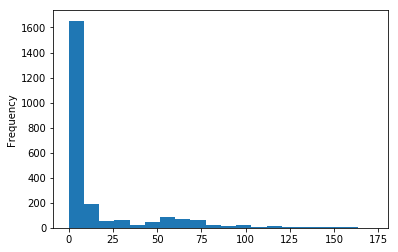

Firebird


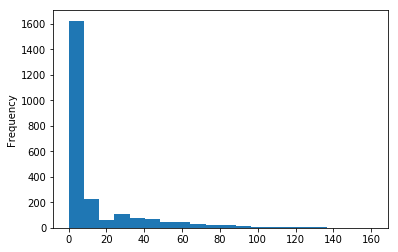

MonetDB


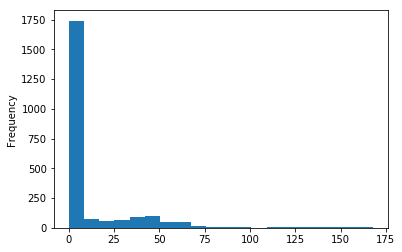

MS SQL Server


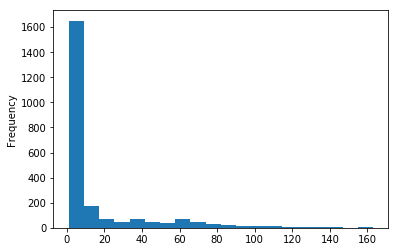

MariaDB


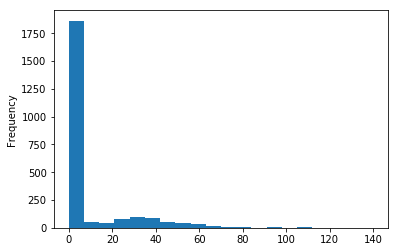

Oracle


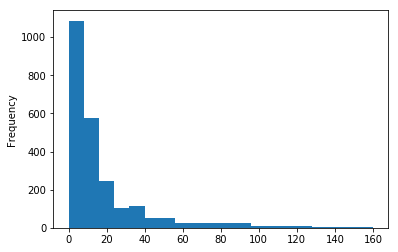

PostgreSQL


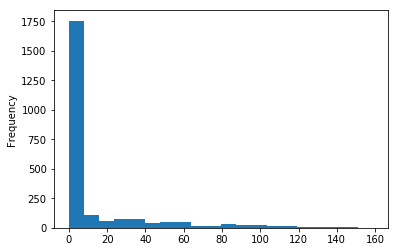

SQLite


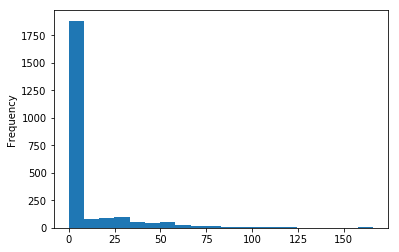

Teradata


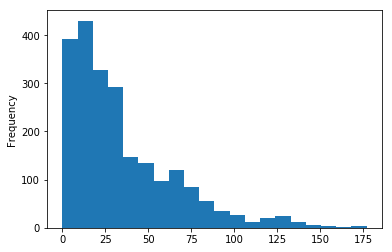

In [44]:
def to_float(x):
    try:
        return float(x)
    except:
        # print("PROBLEM_CONVERTING" , x)
        return None

import matplotlib.pyplot as plt
for dialect in dialects:
    print(dialect)
    df1 = df[df.dialect == dialect] # .sample(4000)
    times = df1['elapsed_time'].apply(to_float)
    # times= times[times > 100]
    times.plot(kind='hist' , bins=20)
    plt.show()
